Baseline Modeling

Derived from B02: ML Examples

In [56]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, PRCurve
from yellowbrick.model_selection import LearningCurve
import catboost
import xgboost

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [44]:
#load in the training data
df = pd.read_pickle('demo_training.pkl')

In [45]:
cat_vars = df[['first_wardid','first_careunit','hospital_expire_flag',
                'admission_type','admission_location','insurance','diagnosis']]
cat_dummies = pd.get_dummies(cat_vars, drop_first=True)
cat_dummies.head()

df = df.drop(['first_wardid','first_careunit','hospital_expire_flag',
                'admission_type','admission_location','insurance','diagnosis'], axis=1)
df = pd.concat([df, cat_dummies], axis=1)

In [46]:
X = df.drop(columns = ['hospital_expire_flag_1.0'])
y = df['hospital_expire_flag_1.0']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1125, stratify=y)

In [48]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y = y.values.ravel()
y_train = y_train.values.ravel()
y_test =y_test.values.ravel()

In [49]:
pd.Series(y_test).value_counts(normalize=True)

0    0.676471
1    0.323529
dtype: float64

In [59]:
# sl_modles = dict(
#     dummy = DummyClassifier(strategy='prior'),
#     knn = KNeighborsClassifier(),
#     lr = LogisticRegression(),
#     svc = SVC(),
#     nn = MLPClassifier(max_iter=500),
#     dtree = DecisionTreeClassifier(),
#     rf=RandomForestClassifier(n_estimators=100),
#     xgb = XGBClassifier(), 
# )

# for name, clf in sl_modles.items():
#     clf.fit(X_train, y_train)
#     score = clf.score(X_test, y_test)
#     print(f'{name}: {score:.3f}')

In [51]:
models = [    
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    SVC,
    RandomForestClassifier,
    xgboost.XGBRFClassifier,
    catboost.CatBoostClassifier,
]

for model in models:
    if model.__name__ == 'XGBRFClassifier':
        clf = model(eval_metric='logloss')
    elif model.__name__ == 'CatBoostClassifier':
        clf = model(verbose=False)
    else:
        clf = model()
    kfold = model_selection.KFold(
        n_splits=10, 
        shuffle=True,
        random_state=123,
    )
    s = model_selection.cross_val_score(
        clf, X, y, scoring='roc_auc', cv=kfold,
    )
    print(
        f'{model.__name__:22} AUC:'
        f'{s.mean():.3f} STD: {s.std():.2f}'
    )

DummyClassifier        AUC:0.547 STD: 0.12
LogisticRegression     AUC:0.996 STD: 0.01
DecisionTreeClassifier AUC:1.000 STD: 0.00
KNeighborsClassifier   AUC:0.909 STD: 0.10
SVC                    AUC:0.985 STD: 0.02
RandomForestClassifier AUC:1.000 STD: 0.00
XGBRFClassifier        AUC:1.000 STD: 0.00
CatBoostClassifier     AUC:1.000 STD: 0.00


In [52]:
# stacking
estimators = []
for model in models:
    if model.__name__ == 'XGBRFClassifier':
        clf = model(eval_metric='logloss')
    elif model.__name__ == 'CatBoostClassifier':
        clf = model(verbose=False)
    else:
        clf = model()
    estimators.append((model.__name__, clf))
    
stack = StackingClassifier(estimators=estimators)

s = model_selection.cross_val_score(
    stack, X, y, scoring='roc_auc', cv=kfold,
)
print(
    f'{stack.__class__.__name__:22} AUC:'
    f'{s.mean():.3f} STD: {s.std():.2f}'
)

StackingClassifier     AUC:1.000 STD: 0.00


In [53]:
# create and optimize model
clf = xgboost.XGBRFClassifier(eval_metric='logloss')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
roc_auc_score(
    y_test, clf.predict(X_test)
)

#sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: -x[1])
clf_ = xgboost.XGBRFClassifier(eval_metric='logloss')
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.5, 1, 1.5, 2, 5],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [4, 5, 6, 7],
}
clf = model_selection.GridSearchCV(
    clf_, params, n_jobs=-1, 
).fit(X_train, y_train)
clf.best_params_
clf.score(X_test, y_test)
clf_best = xgboost.XGBRFClassifier(**clf.best_params_)

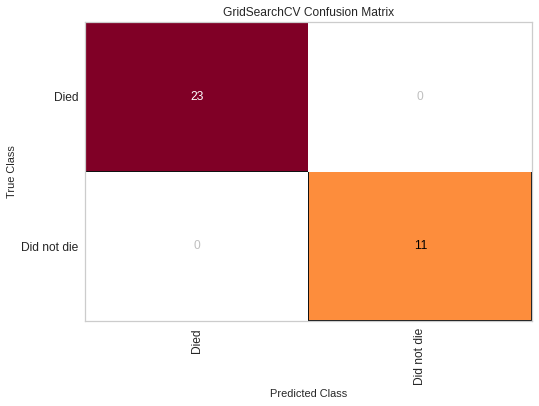

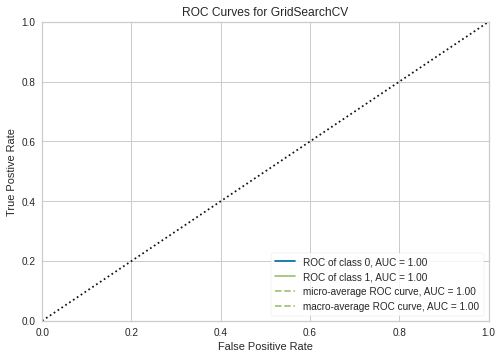

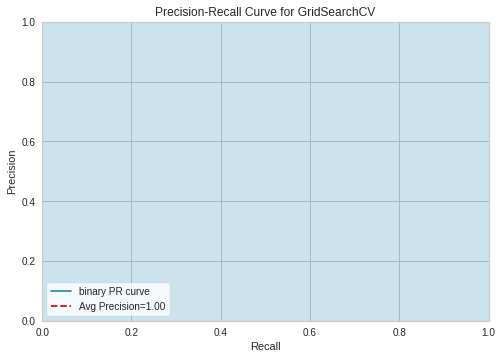

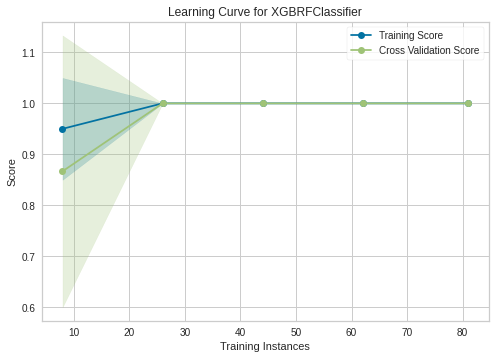

<AxesSubplot:title={'center':'Learning Curve for XGBRFClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [57]:
# confusion matrix, ROC curve, precision-recall, learning curve
clf_best.fit(X_train, y_train)
confusion_matrix(y_test, clf_best.predict(X_test))
cm_viz = ConfusionMatrix(clf, classes=['Died', 'Did not die'])
cm_viz.fit(X_train, y_train)
cm_viz.score(X_test, y_test)
cm_viz.show()

roc_auc_score(y_test, clf_best.predict(X_test))
roc_viz = ROCAUC(clf)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
roc_viz.show()

prc_viz = PRCurve(clf)
prc_viz.fit(X_train, y_train)
prc_viz.score(X_test, y_test)
prc_viz.show()

lc_viz = LearningCurve(clf_best)
lc_viz.fit(X_train, y_train)
lc_viz.score(X_test, y_test)
lc_viz.show()

In [58]:
# model deployment
import joblib
joblib.dump(clf_best, 'clf_best.pickle')
clf = joblib.load('clf_best.pickle')
clf.score(X_test, y_test)

1.0